In [21]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
#import tensorflow as tf
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.optim.lr_scheduler import LinearLR

from transformers import AutoModelForImageClassification, ViTForImageClassification, \
                         ViTFeatureExtractor, Trainer, TrainingArguments, \
                         AutoFeatureExtractor, DeiTForImageClassificationWithTeacher, \
                         BeitForImageClassification, BeitFeatureExtractor
                         # PerceiverFeatureExtractor, PerceiverForImageClassificationConvProcessing

from AutoAugment.autoaugment import ImageNetPolicy

from PIL import Image
import cv2

from tqdm import tqdm
from collections import defaultdict, OrderedDict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [4]:
df = pd.read_csv("../data/train_labels.csv", names=['img_name', 'label'], header=1)

df = df.append([df[df["label"] == 20]] * 15, ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(31016, 2)

In [41]:
def remove_background(img):
    # Apply thresholds for the bound selection
    img = np.asarray(img)
    
    threshold1,threshold2 = 40, 500
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.Canny(img, threshold1, threshold2)

    # Convert images to correct sizes
    image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

    # Applying grey scale and applying the bounds --> These need to be optimized.
    new_image = img * image_new + (1 - grey_new)
    new_image = img * ((new_image > 40) * (new_image < 230))
       
    return Image.fromarray(np.uint8(new_image))    

In [42]:
class food_set(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None, settype = "train"):
        if settype == "train":
            self.img_labels = df[:30000]
        elif settype == "val":
            self.img_labels = df[30000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        # image = remove_background(image)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]      
        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [43]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [44]:
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(768, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 81)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier
model = model.to(device)

In [45]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

In [46]:
def train_loop(trainloader, valloader, model, criterion, optimizer, scheduler = None):
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        for epoch in range(5):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)["logits"]
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'../../beit_2_fc_bg_removal_imgnetpol.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()
            
            if scheduler:
                scheduler.step()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)["logits"]
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [47]:
weights = [i[0] for i in (1 / (df.groupby("label").count() / len(df) * 100)).values]
weights.append(0)
weights = torch.Tensor(np.array(weights)).to(device)

In [48]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01, momentum = 0.9)
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0002, betas=[0.9, 0.999])

scheduler = LinearLR(optimizer)

In [49]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

# Resize image to match BEiT, convert to torch.float, normalize
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       ImageNetPolicy(),
                                       transforms.RandomHorizontalFlip()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224)])

feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [50]:
trainset = food_set(labels, img_dir, feature_extractor, transform = train_transforms, settype = "train")
valset = food_set(labels, img_dir, feature_extractor, transform = test_transforms, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

len(trainset), len(valset)

(30000, 1016)

In [51]:
testset = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(testset, batch_size = 16)

len(testset)

7653

loss: 1.422369  [    0/30000] epoch: 1
loss: 1.430508  [ 1600/30000] epoch: 1
loss: 0.545031  [ 3200/30000] epoch: 1
loss: 1.640277  [ 4800/30000] epoch: 1
loss: 0.394577  [ 6400/30000] epoch: 1
loss: 0.846638  [ 8000/30000] epoch: 1
loss: 0.950632  [ 9600/30000] epoch: 1
loss: 0.598641  [11200/30000] epoch: 1
loss: 0.743773  [12800/30000] epoch: 1
loss: 1.377707  [14400/30000] epoch: 1
loss: 1.454541  [16000/30000] epoch: 1
loss: 2.065812  [17600/30000] epoch: 1
loss: 1.586621  [19200/30000] epoch: 1
loss: 2.284018  [20800/30000] epoch: 1
loss: 1.890637  [22400/30000] epoch: 1
loss: 1.900556  [24000/30000] epoch: 1
loss: 2.041663  [25600/30000] epoch: 1
loss: 1.843141  [27200/30000] epoch: 1
loss: 1.116338  [28800/30000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 70.8%, Avg loss: 1.167492 



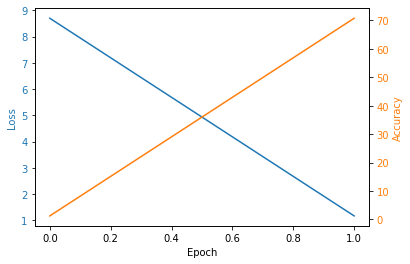

loss: 1.038394  [    0/30000] epoch: 2
loss: 1.308511  [ 1600/30000] epoch: 2
loss: 1.220911  [ 3200/30000] epoch: 2
loss: 2.150705  [ 4800/30000] epoch: 2
loss: 1.267151  [ 6400/30000] epoch: 2
loss: 1.618135  [ 8000/30000] epoch: 2
loss: 1.119319  [ 9600/30000] epoch: 2
loss: 2.261527  [11200/30000] epoch: 2
loss: 0.932593  [12800/30000] epoch: 2
loss: 1.399997  [14400/30000] epoch: 2
loss: 0.916867  [16000/30000] epoch: 2
loss: 3.265604  [17600/30000] epoch: 2
loss: 1.281155  [19200/30000] epoch: 2
loss: 1.128705  [20800/30000] epoch: 2
loss: 0.267743  [22400/30000] epoch: 2
loss: 1.962068  [24000/30000] epoch: 2
loss: 1.534317  [25600/30000] epoch: 2
loss: 1.627284  [27200/30000] epoch: 2
loss: 1.321042  [28800/30000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 71.1%, Avg loss: 1.147321 



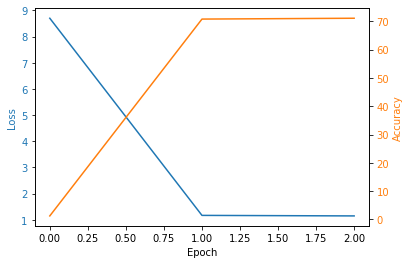

loss: 1.464295  [    0/30000] epoch: 3
loss: 0.770217  [ 1600/30000] epoch: 3
loss: 0.633615  [ 3200/30000] epoch: 3
loss: 1.100450  [ 4800/30000] epoch: 3
loss: 1.722929  [ 6400/30000] epoch: 3
loss: 1.574654  [ 8000/30000] epoch: 3
loss: 0.991703  [ 9600/30000] epoch: 3
loss: 1.564118  [11200/30000] epoch: 3
loss: 0.878242  [12800/30000] epoch: 3
loss: 2.512037  [14400/30000] epoch: 3
loss: 2.411611  [16000/30000] epoch: 3
loss: 0.918228  [17600/30000] epoch: 3
loss: 1.776257  [19200/30000] epoch: 3
loss: 1.042340  [20800/30000] epoch: 3
loss: 0.730905  [22400/30000] epoch: 3
loss: 0.827491  [24000/30000] epoch: 3
loss: 1.254757  [25600/30000] epoch: 3
loss: 1.186708  [27200/30000] epoch: 3
loss: 0.893290  [28800/30000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 69.8%, Avg loss: 1.151924 



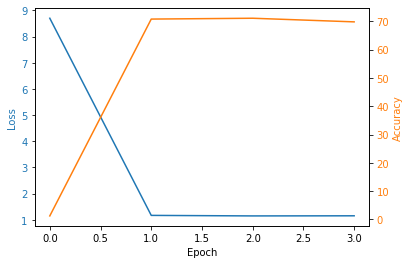

loss: 1.365929  [    0/30000] epoch: 4
loss: 0.802642  [ 1600/30000] epoch: 4
loss: 0.624218  [ 3200/30000] epoch: 4
loss: 1.571996  [ 4800/30000] epoch: 4
loss: 1.290019  [ 6400/30000] epoch: 4
loss: 1.566912  [ 8000/30000] epoch: 4
loss: 1.882662  [ 9600/30000] epoch: 4
loss: 1.061138  [11200/30000] epoch: 4
loss: 0.932627  [12800/30000] epoch: 4
loss: 1.864219  [14400/30000] epoch: 4
loss: 1.796896  [16000/30000] epoch: 4
loss: 0.933903  [17600/30000] epoch: 4
loss: 1.000579  [19200/30000] epoch: 4


In [53]:
stats = train_loop(trainloader, valloader, model, criterion, optimizer)

In [15]:
pd.DataFrame(stats).to_csv("training_beit_data_aug_big_29k_30_epochs_imgnetpol.csv")

In [16]:
PATH = f'./beit_2_fc_29k_30_epochs_imgnetpol.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = model(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 479/479 [02:43<00:00,  2.94it/s]


In [18]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,80
1,test_10.jpg,45
2,test_100.jpg,25
3,test_1000.jpg,29
4,test_1001.jpg,37


In [19]:
test_df.to_csv("./submissions/submission_beit_fc2_30_epochs_imgnetpol.csv", index=False)